In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm
from joblib import Parallel, delayed

In [3]:
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot, wspace=0.0, hspace=0.0)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot, wspace=0.0, hspace=0.0) 

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [85]:
n_dim = 3
rho = 5
i, j = np.meshgrid(np.arange(1, n_dim + 1), np.arange(1, n_dim + 1), indexing="ij")

# Calculate the covariance matrix using the corrected formula
1/rho ** np.abs(i - j)



array([[1.  , 0.2 , 0.04],
       [0.2 , 1.  , 0.2 ],
       [0.04, 0.2 , 1.  ]])

In [125]:
def _autoregressive_cov(n_dim, rho):
    # Create a meshgrid of indices
    i, j = np.meshgrid(np.arange(1, n_dim + 1), np.arange(1, n_dim + 1), indexing="ij")

    # Calculate the covariance matrix using the corrected formula
    # cov_matrix = rho ** np.abs(i - j)
    cov_matrix = 1/(rho ** np.abs(i - j))
    return cov_matrix
    
MARRON_WAND_SIMS = {
    "gaussian" : [1, [1]],
    "skewed_unimodal" : [3, [1/5, 1/5, 3/5]],
    "strongly_skewed" : [8, [1/8] * 8],
    "kurtotic_unimodal" : [2, [2/3, 1/3]],
    "outlier" : [2, [1/10, 9/10]],
    "bimodal" : [2, [1/2] * 2],
    "separated_bimodal" : [2, [1/2] * 2],
    "skewed_bimodal" : [2, [3/4, 1/4]],
    "trimodal" : [3, [9/20, 9/20, 1/10]],
    "claw" : [6, [1/2, *[1/10] * 5]],
    "double_claw" : [9, [49/100, 49/100, *[1/350] * 7]],
    "asymmetric_claw" : [6, [1/2, *[2 ** (1 - i) / 31 for i in range(-2, 3)]]],
    "asymmetric_double_claw" : [8, [*[46/100] * 2, *[1/300] * 3,  *[7/300] * 3]],
    "smooth_comb" : [6, [2 ** (5 - i) / 63 for i in range(6)]],
    "discrete_comb" : [6, [*[2/7] * 3, *[1/21] * 3]],
}

def make_trunk_classification(
    n_samples,
    n_dim=10,
    m_factor: int = -1,
    rho: int = 0,
    band_type: str = "ar",
    return_params: bool = False,
    simulation : str = "trunk",
    seed=None,
):
    rng = np.random.default_rng(seed=seed)

    mu_1 = np.array([1 / np.sqrt(i) if i <= 256 else 0 for i in range(1, n_dim + 1)])
    mu_0 = m_factor * mu_1
    w = np.array([1 / np.sqrt(i) if i <= 256 else 0 for i in range(1, n_dim + 1)])

    if rho != 0:
        if band_type == "ma":
            cov = _moving_avg_cov(n_dim, rho)
        elif band_type == "ar":
            cov = _autoregressive_cov(n_dim, rho)
        else:
            raise ValueError(f'Band type {band_type} must be one of "ma", or "ar".')
    else:
        cov = np.identity(n_dim)

    if n_dim > 1000:
        method = "cholesky"
    else:
        method = "svd"

    if simulation == "trunk":
        X = np.vstack(
            (
                rng.multivariate_normal(mu_1, cov, n_samples // 2, method=method),
                rng.multivariate_normal(mu_0, cov, n_samples // 2, method=method),
            )
        )
    elif simulation == "trunk_overlap":
        X = np.vstack(
            (
                rng.multivariate_normal(np.zeros(n_dim), cov, n_samples // 2, method=method),
                rng.multivariate_normal(np.zeros(n_dim), cov, n_samples // 2, method=method),
            )
        )
    elif simulation == "trunk_mix":
        mixture_idx = rng.choice(
            2, n_samples // 2, replace=True, shuffle=True, p=None
        )
        norm_params = [[mu_0, cov * (2/3) ** 2], [mu_1, cov * (2/3) ** 2]]
        X_mixture = np.fromiter(
            (rng.multivariate_normal(*(norm_params[i]), size=1, method=method) for i in mixture_idx),
            dtype=np.dtype((float, n_dim))
        )
        # X_mixture = np.zeros((n_samples // 2, len(mu_1)))
        # for idx in range(n_samples // 2):
        #     if mixture_idx[idx] == 1:
        #         X_sample = rng.multivariate_normal(mu_1, , 1, method=method)
        #     else:
        #         X_sample = rng.multivariate_normal(mu_0, cov * (2/3) ** 2, 1, method=method)
        #     X_mixture[idx, :] = X_sample

        X = np.vstack(
            (
                rng.multivariate_normal(np.zeros(n_dim), cov*(2/3)**2, n_samples // 2, method=method),
                X_mixture.reshape(n_samples // 2, n_dim),
            )
        )
    elif simulation in MARRON_WAND_SIMS.keys():
        mixture_idx = rng.choice(
            MARRON_WAND_SIMS[simulation][0], size=n_samples // 2, replace=True, p=MARRON_WAND_SIMS[simulation][1]
        )
        norm_params = MarronWandSims(n_dim=n_dim, cov=cov)(simulation)
        G = np.fromiter(
            (rng.multivariate_normal(*(norm_params[i]), size=1, method=method) for i in mixture_idx),
            dtype=np.dtype((float, n_dim))
        )
    
        X = np.vstack(
            (
                rng.multivariate_normal(np.zeros(n_dim), cov, n_samples // 2, method=method),
                (1 - w) * rng.multivariate_normal(np.zeros(n_dim), cov, n_samples // 2, method=method)
                + w * G.reshape(n_samples // 2, n_dim),
            )
        )
    else:
        raise ValueError(f"Simulation must be trunk, trunk_overlap, trunk_mix, {MARRON_WAND_SIMS.keys()}")

    y = np.concatenate((np.zeros(n_samples // 2), np.ones(n_samples // 2)))

    if return_params:
        return X, y, [mu_0, mu_1], [cov, cov]
    return X, y


class MarronWandSims:
    def __init__(self, n_dim=1, cov=1):
        self.n_dim = n_dim
        self.cov = cov

    def __call__(self, simulation):
        sims = self._my_method_generator()
        if simulation in sims.keys():
            return sims[simulation]()
        else:
            raise ValueError(f"simulation is not one of these: {sims.keys()}")

    def _my_method_generator(self):
        return {method: getattr(self, method) for method in dir(self) if not method.startswith("__")}

    def gaussian(self):
        return [[np.zeros(self.n_dim), self.cov]]
    
    def skewed_unimodal(self):
        return [
            [np.zeros(self.n_dim), self.cov],
            [np.full(self.n_dim, 1/2), self.cov * (2/3) ** 2],
            [np.full(self.n_dim, 13/12), self.cov * (5/9) ** 2]
        ]
    
    def strongly_skewed(self):
        return [
            [np.full(self.n_dim, 3 * ((2/3) ** l - 1)), self.cov * (2/3) ** (2 * l)] for l in range(8)
        ]
    
    def kurtotic_unimodal(self):
        return [
            [np.zeros(self.n_dim), self.cov],
            [np.zeros(self.n_dim), self.cov * (1/10) ** 2]
        ]

    def outlier(self):
        return [
            [np.zeros(self.n_dim), self.cov],
            [np.zeros(self.n_dim), self.cov * (1/10) ** 2]
        ]
    
    def bimodal(self):
        return [
            [-np.ones(self.n_dim), self.cov * (2/3) ** 2],
            [np.ones(self.n_dim), self.cov * (2/3) ** 2]
        ]
    
    def separated_bimodal(self):
        return [
            [-np.full(self.n_dim, 3/2), self.cov * (1/2) ** 2],
            [np.full(self.n_dim, 3/2), self.cov * (1/2) ** 2]
        ]
    
    def skewed_bimodal(self):
        return [
            [np.zeros(self.n_dim), self.cov],
            [np.full(self.n_dim, 3/2), self.cov * (1/3) ** 2]
        ]
    
    def trimodal(self):
        return [
            [np.full(self.n_dim, -6/5), self.cov * (3/5) ** 2],
            [np.full(self.n_dim, 6/5), self.cov * (3/5) ** 2],
            [np.zeros(self.n_dim), self.cov * (1/4) ** 2]
        ]
    
    def claw(self):
        return [
            [np.zeros(self.n_dim), self.cov],
            *[[np.full(self.n_dim, (l / 2) - 1), self.cov * (1/10) ** 2] for l in range(5)]
        ]
    
    def double_claw(self):
        return [
            [-np.ones(self.n_dim), self.cov * (2/3) ** 2],
            [np.ones(self.n_dim), self.cov * (2/3) ** 2],
            *[[np.full(self.n_dim, (l - 3) / 2), self.cov * (1/100) ** 2] for l in range(7)]
        ]
    
    def asymmetric_claw(self):
        return [
            [np.zeros(self.n_dim), self.cov],
            *[[np.full(self.n_dim, l + 1/2), self.cov * (1 / ((2 ** l) *  10)) ** 2] for l in range(-2, 3)]
        ]
    
    def asymmetric_double_claw(self):
        return [
            *[[np.full(self.n_dim, 2 * l - 1), self.cov * (2/3) ** 2] for l in range(2)],
            *[[-np.full(self.n_dim, l / 2), self.cov * (1/100) ** 2] for l in range(1, 4)],
            *[[np.full(self.n_dim, l / 2), self.cov * (7/100) ** 2] for l in range(1, 4)]
        ]
    
    def smooth_comb(self):
        return [
            [np.full(self.n_dim, (65 - 96 * ((1/2) ** l)) / 21), self.cov * (32/63) ** 2 / (2 ** (2 * l))] for l in range(6)
        ]
    
    def discrete_comb(self):
        return [
            *[[np.full(self.n_dim, (12 * l - 15) / 7), self.cov * (2/7) ** 2] for l in range(3)],
            *[[np.full(self.n_dim, (2 * l) / 7), self.cov * (1/21) ** 2] for l in range(8, 11)]
        ]

In [126]:
from scipy.stats import norm


class TrueSimulationDensities:
    def __init__(self, min_max=[-3, 3], n_samples=200, n_dim=10, rho=1, band_type="ar"):
        self.min_max = min_max
        self.n_samples = n_samples
        self.n_dim = n_dim
        self.rho = rho

    def __call__(self, simulation):
        self.xs = np.linspace(self.min_max[0], self.min_max[1], self.n_samples)
        self.mean = 1 / np.sqrt(self.n_dim) if self.n_dim <= 256 else 0
        pi = self.mean
        sims = self._my_method_generator()
        # if simulation in MARRON_WAND_SIMS.keys():
        #     pop1 = norm.pdf(self.xs, loc=0, scale=1)
        #     norm_params = sims[simulation]()
        #     weights = MARRON_WAND_SIMS[simulation][1]

        #     G = np.zeros_like(self.xs)
        #     for (l, s), w in zip(norm_params, weights):
        #         G += norm.pdf(self.xs, loc=l, scale=np.sqrt(s)) * w
        #     pop2 = (1 - pi) * norm.pdf(self.xs, loc=0, scale=1) + pi * G
        #     return (self.xs, pop1, pop2)
        if simulation in MARRON_WAND_SIMS.keys():
            pop1 = norm.pdf(self.xs, loc=0, scale=1)
            norm_params = sims[simulation]()
            weights = MARRON_WAND_SIMS[simulation][1]

            # G = np.zeros_like(self.xs)
            # for (l, s), w in zip(norm_params, weights):
            #     G += norm.pdf(self.xs, loc=l, scale=s) * w
            pop2 = np.zeros_like(self.xs)
            for (l, s), w in zip(norm_params, weights):
                pop2 += norm.pdf(self.xs, loc=(l * pi), scale=np.sqrt(pi ** 2 * s ** 2 + (1 - pi) ** 2)) * w
            # pop2 = (1 - pi) * norm.pdf(self.xs, loc=0, scale=1) + pi * G
            return (self.xs, pop1, pop2)
        elif simulation in sims.keys():
            return (self.xs, *sims[simulation]())
        else:
            raise ValueError(f"simulation is not one of these: {sims.keys()}")

    def _my_method_generator(self):
        return {method: getattr(self, method) for method in dir(self) if not method.startswith("__")}

    def trunk(self):
        pop1 = norm.pdf(self.xs, loc=self.mean, scale=1)
        pop2 = norm.pdf(self.xs, loc=-self.mean, scale=1)
        return pop1, pop2

    def trunk_overlap(self):
        pop1 = norm.pdf(self.xs, loc=0, scale=1)
        pop2 = norm.pdf(self.xs, loc=0, scale=1)
        return pop1, pop2

    def trunk_mix(self):
        if self.n_dim > 256:
            return norm.pdf(self.xs, loc=0, scale=1), norm.pdf(self.xs, loc=0, scale=1)

        pop1 = norm.pdf(self.xs, loc=0, scale=2/3)

        if self.n_dim <= 256:
            norm_params = [[-self.mean, 2/3], [self.mean, 2/3]]
        else:
            norm_params = [[0, 2/3], [0, 2/3]]
        weights = [1/2] * 2

        pop2 = np.sum([norm.pdf(self.xs, loc=l, scale=s) * w for (l, s), w in zip(norm_params, weights)], axis=0)
        return pop1, pop2

    def gaussian(self):
        return [[0, 1]]
    
    def skewed_unimodal(self):
        return [
            [0, 1],
            [1/2, 2/3],
            [13/12, 5/9]
        ]
    
    def strongly_skewed(self):
        return [
            [3 * ((2/3) ** l - 1), (2/3) ** l] for l in range(8)
        ]
    
    def kurtotic_unimodal(self):
        return [
            [0, 1],
            [0, 1/10]
        ]

    def outlier(self):
        return [
            [0, 1],
            [0, 1/10]
        ]
    
    def bimodal(self):
        return [
            [-1, 2/3],
            [1, 2/3]
        ]
    
    def separated_bimodal(self):
        return [
            [-3/2, 1/2],
            [3/2, 1/2]
        ]
    
    def skewed_bimodal(self):
        return [
            [0, 1],
            [3/2, 1/3]
        ]
    
    def trimodal(self):
        return [
            [-6/5, 3/5],
            [6/5, 3/5],
            [0, 1/4]
        ]
    
    def claw(self):
        return [
            [0, 1],
            *[[(l / 2) - 1, 1/10] for l in range(5)]
        ]
    
    def double_claw(self):
        return [
            [-1, 2/3],
            [1, 2/3],
            *[[(l - 3) / 2, 1/100] for l in range(7)]
        ]
    
    def asymmetric_claw(self):
        return [
            [0, 1],
            *[[l + 1/2, 1 / ((2 ** l) *  10)] for l in range(-2, 3)]
        ]
    
    def asymmetric_double_claw(self):
        return [
            *[[2 * l - 1, 2/3] for l in range(2)],
            *[[-l / 2, 1/100] for l in range(1, 4)],
            *[[l / 2, 7/100] for l in range(1, 4)]
        ]
    
    def smooth_comb(self):
        return [
            [(65 - 96 * ((1/2) ** l)) / 21, (32/63) / (2 ** l)] for l in range(6)
        ]
    
    def discrete_comb(self):
        return [
            *[[(12 * l - 15) / 7, 2/7] for l in range(3)],
            *[[(2 * l) / 7, 1/21] for l in range(8, 11)]
        ]

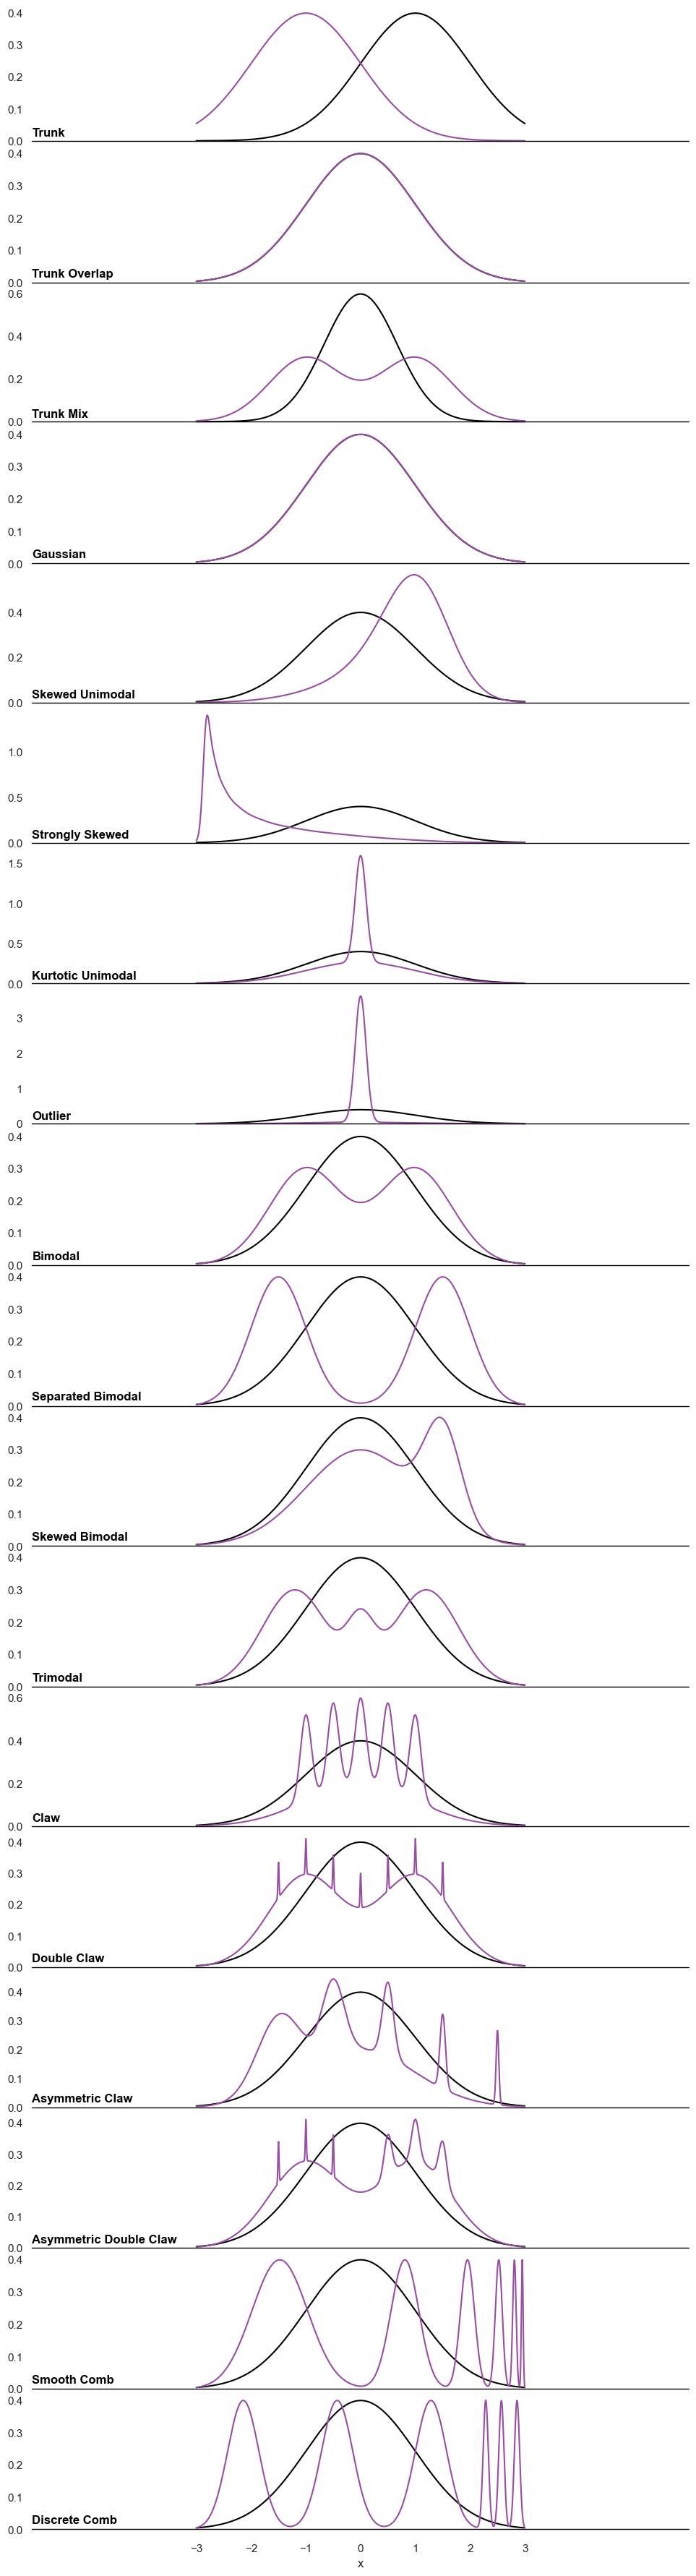

In [128]:
plot_true_sims_dimensions(n=1000, DIM=1)

In [107]:
# from scipy.stats import norm


# class TrueSimulationDensities:
#     def __init__(self, min_max=[-3, 3], n_samples=200, n_dim=10):
#         self.min_max = min_max
#         self.n_samples = n_samples
#         self.n_dim = n_dim

#     def __call__(self, simulation):
#         self.xs = np.linspace(self.min_max[0], self.min_max[1], self.n_samples)
#         self.mean = 1 / np.sqrt(self.n_dim) if self.n_dim <= 256 else 0
#         pi = self.mean
#         sims = self._my_method_generator()
#         if simulation in MARRON_WAND_SIMS.keys():
#             pop1 = norm.pdf(self.xs, loc=0, scale=1)
#             norm_params = sims[simulation]()
#             weights = MARRON_WAND_SIMS[simulation][1]

#             G = np.zeros_like(self.xs)
#             for (l, s), w in zip(norm_params, weights):
#                 G += norm.pdf(self.xs, loc=l, scale=s) * w
#             pop2 = (1 - pi) * norm.pdf(self.xs, loc=0, scale=1) + pi * G
#             return (self.xs, pop1, pop2)
#         elif simulation in sims.keys():
#             return (self.xs, *sims[simulation]())
#         else:
#             raise ValueError(f"simulation is not one of these: {sims.keys()}")

#     def _my_method_generator(self):
#         return {method: getattr(self, method) for method in dir(self) if not method.startswith("__")}

#     def trunk(self):
#         pop1 = norm.pdf(self.xs, loc=self.mean, scale=1)
#         pop2 = norm.pdf(self.xs, loc=-self.mean, scale=1)
#         return pop1, pop2

#     def trunk_overlap(self):
#         pop1 = norm.pdf(self.xs, loc=0, scale=1)
#         pop2 = norm.pdf(self.xs, loc=0, scale=1)
#         return pop1, pop2

#     def trunk_mix(self):
#         if self.n_dim > 256:
#             return norm.pdf(self.xs, loc=0, scale=1), norm.pdf(self.xs, loc=0, scale=1)

#         pop1 = norm.pdf(self.xs, loc=0, scale=(2/3) ** 2)

#         norm_params = [[-self.mean, (2/3) ** 2], [self.mean, (2/3) ** 2]]
#         weights = [1/2] * 2

#         pop2 = np.sum([norm.pdf(self.xs, loc=l, scale=s) * w for (l, s), w in zip(norm_params, weights)], axis=0)
#         return pop1, pop2

#     def gaussian(self):
#         return [[0, 1]]
    
#     def skewed_unimodal(self):
#         return [
#             [0, 1],
#             [1/2, 2/3],
#             [13/12, 5/9]
#         ]
    
#     def strongly_skewed(self):
#         return [
#             [3 * ((2/3) ** l - 1), (2/3) ** l] for l in range(8)
#         ]
    
#     def kurtotic_unimodal(self):
#         return [
#             [0, 1],
#             [0, 1/10]
#         ]

#     def outlier(self):
#         return [
#             [0, 1],
#             [0, 1/10]
#         ]
    
#     def bimodal(self):
#         return [
#             [-1, 2/3],
#             [1, 2/3]
#         ]
    
#     def separated_bimodal(self):
#         return [
#             [-3/2, 1/2],
#             [3/2, 1/2]
#         ]
    
#     def skewed_bimodal(self):
#         return [
#             [0, 1],
#             [3/2, 1/3]
#         ]
    
#     def trimodal(self):
#         return [
#             [-6/5, 3/5],
#             [6/5, 3/5],
#             [0, 1/4]
#         ]
    
#     def claw(self):
#         return [
#             [0, 1],
#             *[[(l / 2) - 1, 1/10] for l in range(5)]
#         ]
    
#     def double_claw(self):
#         return [
#             [-1, 2/3],
#             [1, 2/3],
#             *[[(l - 3) / 2, 1/100] for l in range(7)]
#         ]
    
#     def asymmetric_claw(self):
#         return [
#             [0, 1],
#             *[[l + 1/2, 1 / ((2 ** l) *  10)] for l in range(-2, 3)]
#         ]
    
#     def asymmetric_double_claw(self):
#         return [
#             *[[2 * l - 1, 2/3] for l in range(2)],
#             *[[-l / 2, 1/100] for l in range(1, 4)],
#             *[[l / 2, 7/100] for l in range(1, 4)]
#         ]
    
#     def smooth_comb(self):
#         return [
#             [(65 - 96 * ((1/2) ** l)) / 21, (32/63) / (2 ** l)] for l in range(6)
#         ]
    
#     def discrete_comb(self):
#         return [
#             *[[(12 * l - 15) / 7, 2/7] for l in range(3)],
#             *[[(2 * l) / 7, 1/21] for l in range(8, 11)]
#         ]

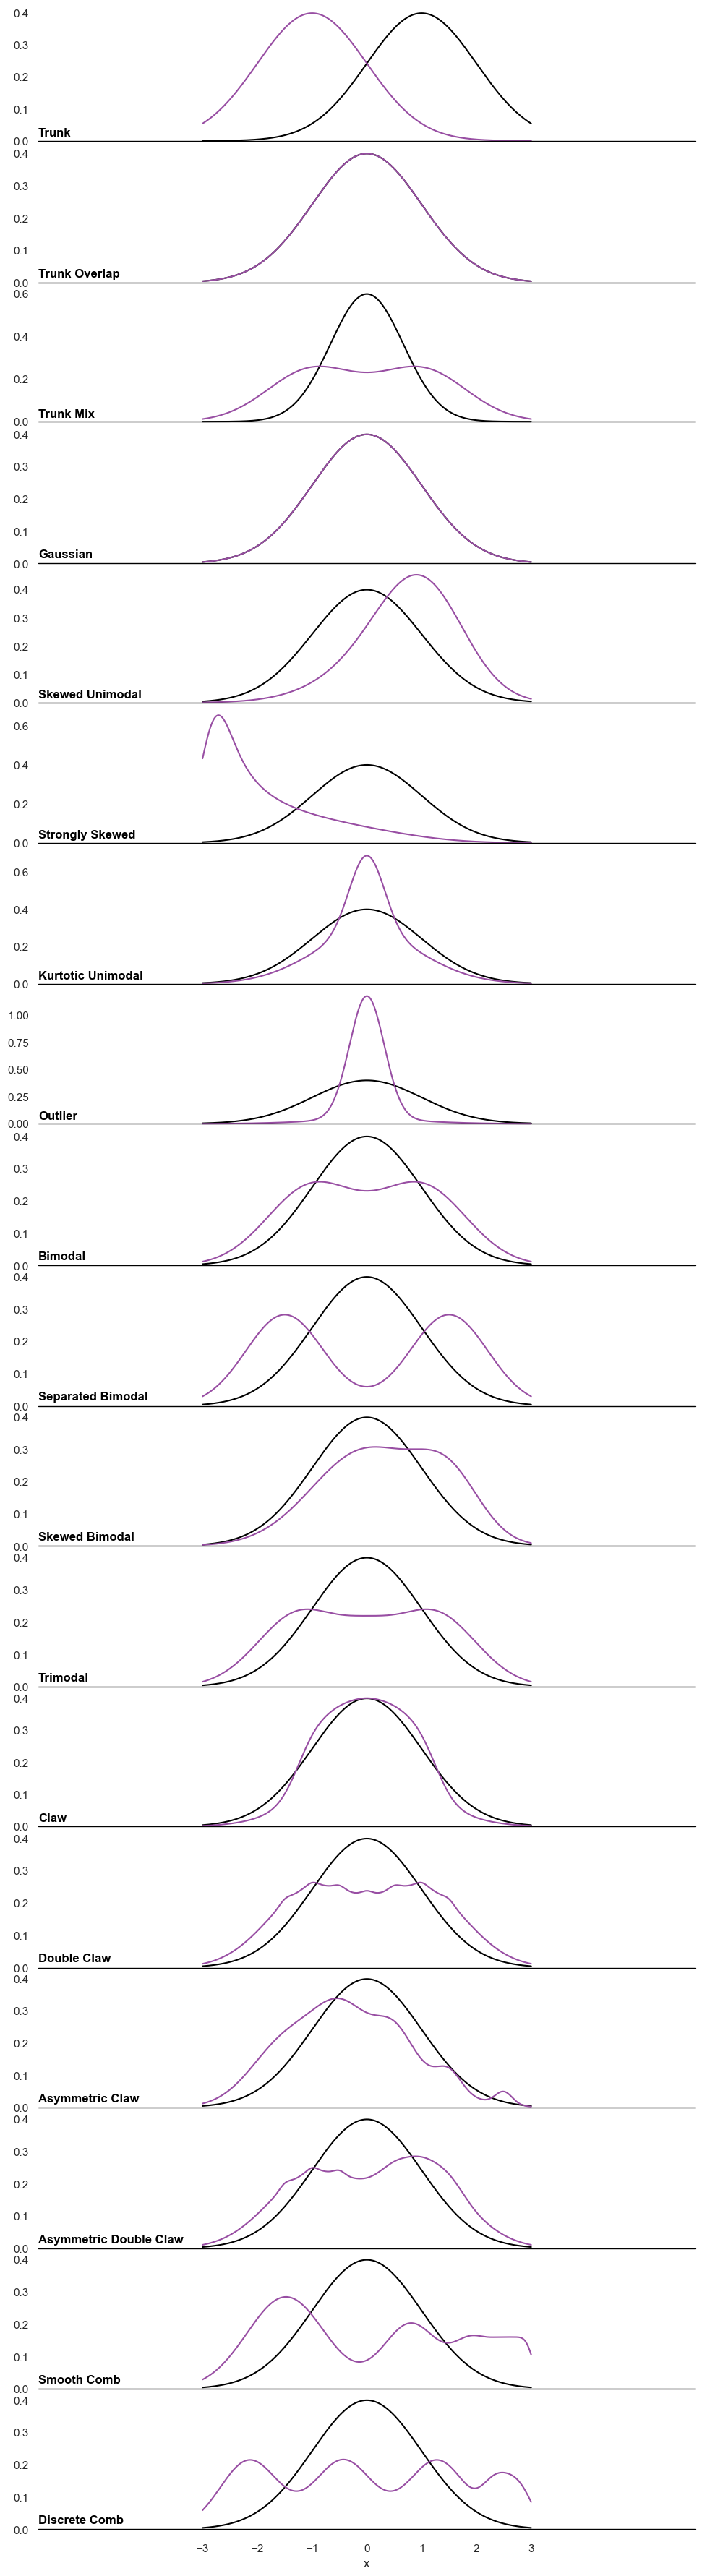

In [115]:
plot_true_sims_dimensions(n=1000, DIM=1)

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
sns.set_palette(sns.color_palette(["#000000", "#984ea3"]))

OUTDIR = "./figs/"
NROWS = 3
NCOLS = 3
DIMS = [2**i for i in range(NROWS*NCOLS+2)]

SIMULATIONS = {
    "Trunk" : {"simulation" : "trunk"},
    "Trunk Overlap" : {"simulation" : "trunk_overlap"},
    "Trunk Mix" : {"simulation" : "trunk_mix"},
    "Gaussian" : {"simulation" : "gaussian"},
    "Skewed Unimodal" : {"simulation" : "skewed_unimodal"},
    "Strongly Skewed" : {"simulation" : "strongly_skewed"},
    "Kurtotic Unimodal" : {"simulation" : "kurtotic_unimodal"},
    "Outlier" : {"simulation" : "outlier"},
    "Bimodal" : {"simulation" : "bimodal"},
    "Separated Bimodal" : {"simulation" : "separated_bimodal"},
    "Skewed Bimodal" : {"simulation" : "skewed_bimodal"},
    "Trimodal" : {"simulation" : "trimodal"},
    "Claw" : {"simulation" : "claw"},
    "Double Claw" : {"simulation" : "double_claw"},
    "Asymmetric Claw" : {"simulation" : "asymmetric_claw"},
    "Asymmetric Double Claw" : {"simulation" : "asymmetric_double_claw"},
    "Smooth Comb" : {"simulation" : "smooth_comb"},
    "Discrete Comb" : {"simulation" : "discrete_comb"},
}

def plot_sims_jointplot(n):
    DIMS = [2**i for i in range(NROWS*NCOLS+2)]
    outputs = Parallel(n_jobs=-1, verbose=100)(
        [
            delayed(make_trunk_classification)(n_samples=n, n_dim=DIMS[-1], **sim_kwargs)
            for sim_kwargs in SIMULATIONS.values()
        ]
    )
    outputs_true = []
    for sim, sim_kwargs in SIMULATIONS.items():
        span, pop1, pop2 = TrueSimulationDensities(n_samples=n//2, n_dim=DIMS[-1])(**sim_kwargs)
        outputs_true.append((span, pop1, pop2))
        
    # generate true simulation densities
    # df = pd.DataFrame(dict(x=np.vstack(xs).ravel(), g=g, y=np.vstack(ys).ravel(), 
    #                        spans=np.vstack(spans).ravel(), true_x=np.concatenate(xs_true), true_y=np.concatenate(ys_true)))

    for sim_number, (sim, sim_kwargs) in enumerate(SIMULATIONS.items()):
        fig = plt.figure(figsize=(24, 24))
        gs = gridspec.GridSpec(NROWS, NCOLS, fig, wspace=0.0, hspace=0.0)
        plt.suptitle(
            "Simulation {}".format(sim),
            y=1.0,
            va="baseline",
        )
        for i, g in enumerate(gs):
            X, y = outputs[sim_number]
            df = pd.DataFrame(dict(x=X[:, DIMS[i]], y=X[:, DIMS[i+1]], g=y))
            jplot = sns.JointGrid(data=df, space=0)
            # sns.scatterplot(
            #     x=outputs[sim_number][0][:, DIMS[i]],
            #     y=outputs[sim_number][0][:, DIMS[i+1]],
            #     hue=outputs[sim_number][1],
            #     s=100,
            #     alpha=.5,
            #     marker=".",
            #     legend=False,
            #     ax=jplot.ax_joint,
            #     palette=["#000000", "#984ea3"]
            # )
            jplot.plot_joint(
                sns.scatterplot, hue='g', s=100, alpha=0.5, legend=False,
            )

            jplot.plot_marginals(sns.histplot, hue='g', bins=100, legend=False)
            # xs, pop1, pop2 = TrueSimulationDensities(
            #     n_samples=50000,
            #     min_max=(-3.5, 3.5),
            #     n_dim=DIMS[i])(**sim_kwargs)
            # jplot.ax_marg_x.plot(xs, pop1, color="#000000")
            # jplot.ax_marg_x.plot(xs, pop2, color="#984ea3")
            # xs, pop1, pop2 = TrueSimulationDensities(
            #     n_samples=50000,
            #     min_max=(-3.5, 3.5),
            #     n_dim=DIMS[i+1])(**sim_kwargs)
            # jplot.ax_marg_y.plot(pop1, xs, color="#000000")
            # jplot.ax_marg_y.plot(pop2, xs, color="#984ea3") #"#984ea3"
            jplot.ax_joint.set(
                xticks=[],
                yticks=[],
                xlabel=f"Variable {DIMS[i]}",
                ylabel=f"Variable {DIMS[i+1]}",
                xlim=(-3.5, 3.5),
                ylim=(-3.5, 3.5)
            )
            sns.despine(left=True, bottom=True, right=True)
            SeabornFig2Grid(jplot, fig, g)
            # save the figure
            plt.savefig(f"{OUTDIR}{sim}_{n}.png")
        fig.tight_layout(pad=0, h_pad=1, w_pad=1)

<Axes: xlabel='0', ylabel='1'>

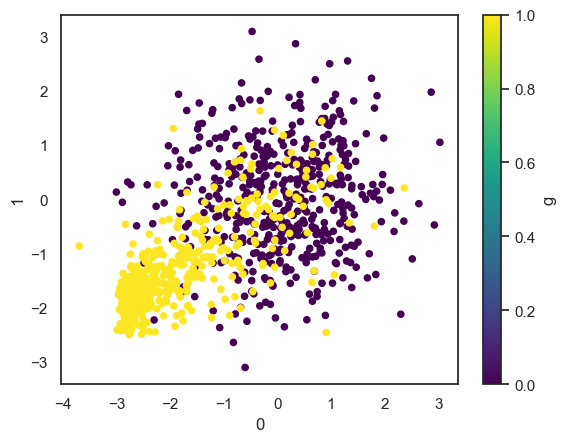

In [33]:


X, y = make_trunk_classification(n_samples=1000, n_dim=10, simulation="strongly_skewed")
df = pd.DataFrame(X)
df['g'] = y
df.plot(kind='scatter', x=0, y=1, c='g', cmap='viridis')
# g = sns.JointGrid(data=df, space=0)
# # g.plot_joint(sns, s=100, alpha=0.5, legend=False)
# g.plot_joint(
#     sns.scatterplot, hue='g', s=100, alpha=0.5, legend=False,
# )
# g.plot_marginals(sns.histplot, bins=100, legend=False)

array([[<Axes: title={'center': '0'}>]], dtype=object)

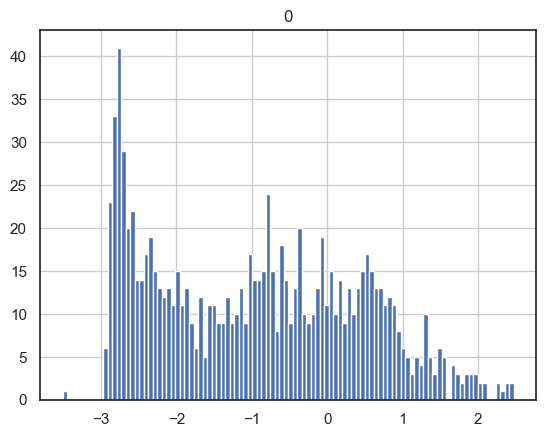

In [27]:
pd.DataFrame(X[:,0]).hist(bins=100)

In [ ]:
# n_sims = len(SIMULATIONS.keys())
# for sim_name in SIMULATIONS.keys():
plot_sims_jointplot(1000)

In [129]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

SIMULATIONS = {
    "Trunk" : {"simulation" : "trunk"},
    "Trunk Overlap" : {"simulation" : "trunk_overlap"},
    "Trunk Mix" : {"simulation" : "trunk_mix"},
    "Gaussian" : {"simulation" : "gaussian"},
    "Skewed Unimodal" : {"simulation" : "skewed_unimodal"},
    "Strongly Skewed" : {"simulation" : "strongly_skewed"},
    "Kurtotic Unimodal" : {"simulation" : "kurtotic_unimodal"},
    "Outlier" : {"simulation" : "outlier"},
    "Bimodal" : {"simulation" : "bimodal"},
    "Separated Bimodal" : {"simulation" : "separated_bimodal"},
    "Skewed Bimodal" : {"simulation" : "skewed_bimodal"},
    "Trimodal" : {"simulation" : "trimodal"},
    "Claw" : {"simulation" : "claw"},
    "Double Claw" : {"simulation" : "double_claw"},
    "Asymmetric Claw" : {"simulation" : "asymmetric_claw"},
    "Asymmetric Double Claw" : {"simulation" : "asymmetric_double_claw"},
    "Smooth Comb" : {"simulation" : "smooth_comb"},
    "Discrete Comb" : {"simulation" : "discrete_comb"},
}

def plot_sims_oned(n):
    # Create the data
    xs = []
    ys = []
    # Create the true pdf data
    xs_true = []
    ys_true = []
    spans = []
    g = np.concatenate([np.repeat(sim_title, n // 2) for sim_title in SIMULATIONS.keys()])
    for sim, sim_kwargs in SIMULATIONS.items():
        x, _ = make_trunk_classification(n_samples=n, n_dim=1, **sim_kwargs)
        xs.append(x[:n // 2, :])
        ys.append(x[n // 2:, :])
        span, pop1, pop2 = TrueSimulationDensities(n_samples=n//2, n_dim=1)(**sim_kwargs)
        xs_true.append(pop1)
        ys_true.append(pop2)
        spans.append(span)
    df = pd.DataFrame(dict(x=np.vstack(xs).ravel(), g=g, y=np.vstack(ys).ravel(), 
                           spans=np.vstack(spans).ravel(), true_x=np.concatenate(xs_true), true_y=np.concatenate(ys_true)))


    # g = np.concatenate([np.repeat(2**i, n // 2) for i in range(1)])
    # x, y = make_trunk_classification(n_samples=n, n_dim=1, **SIMULATIONS[sim])
    # pop1 = np.hstack([x[:n // 2, i-1] for i in set(g)])
    # pop2 = np.hstack([x[n // 2:, i-1] for i in set(g)])
    # df = pd.DataFrame(dict(x=np.ravel(pop1.T), g=g, y=np.ravel(pop2.T)))

    # Initialize the FacetGrid object
    g = sns.FacetGrid(df, row="g", hue="g", aspect=5, height=2, palette=["#000000"], sharey=False)

    # # Draw the densities
    # g.map(sns.kdeplot, "x", clip=(-3, 3), fill=False, alpha=0.5, linewidth=1.5, color="#000000", bw_adjust=.75)
    # g.map(sns.kdeplot, "y", clip=(-3, 3), fill=False, alpha=0.5, linewidth=1.5, color="#984ea3", bw_adjust=.75)
    g.map(sns.histplot, "x", bins=100,color="#000000") #, clip=(-3, 3), fill=False, alpha=0.5, linewidth=1.5, color="#000000")
    g.map(sns.histplot, "y", bins=100, color="#984ea3") #, clip=(-3, 3), fill=False, alpha=0.5, linewidth=1.5, color="#000000")

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=1, linestyle="-", color=None, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, 0.1, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    
    g.map(label, "x")
    
    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=0)
    
    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[0, n/50], ylabel="", xlim=(-6, 6), xticks=[-3, -2, -1, 0, 1, 2, 3])
    g.despine(bottom=True, left=True)

/var/folders/kz/zj0pt1vs2q9fgjg64gkxw7c00000gn/T/ipykernel_51585/4104368285.py:80: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype=np.dtype((float, n_dim))
/var/folders/kz/zj0pt1vs2q9fgjg64gkxw7c00000gn/T/ipykernel_51585/4104368285.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_mixture = np.fromiter(
/var/folders/kz/zj0pt1vs2q9fgjg64gkxw7c00000gn/T/ipykernel_51585/4104368285.py:103: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype=np.dtype((float, n_dim))
/var/folders/kz/zj0pt1vs2q9fgjg64gkxw7c00000gn/T/ipykernel_51585/4104368285.py:101: DeprecationWarning: Conversi

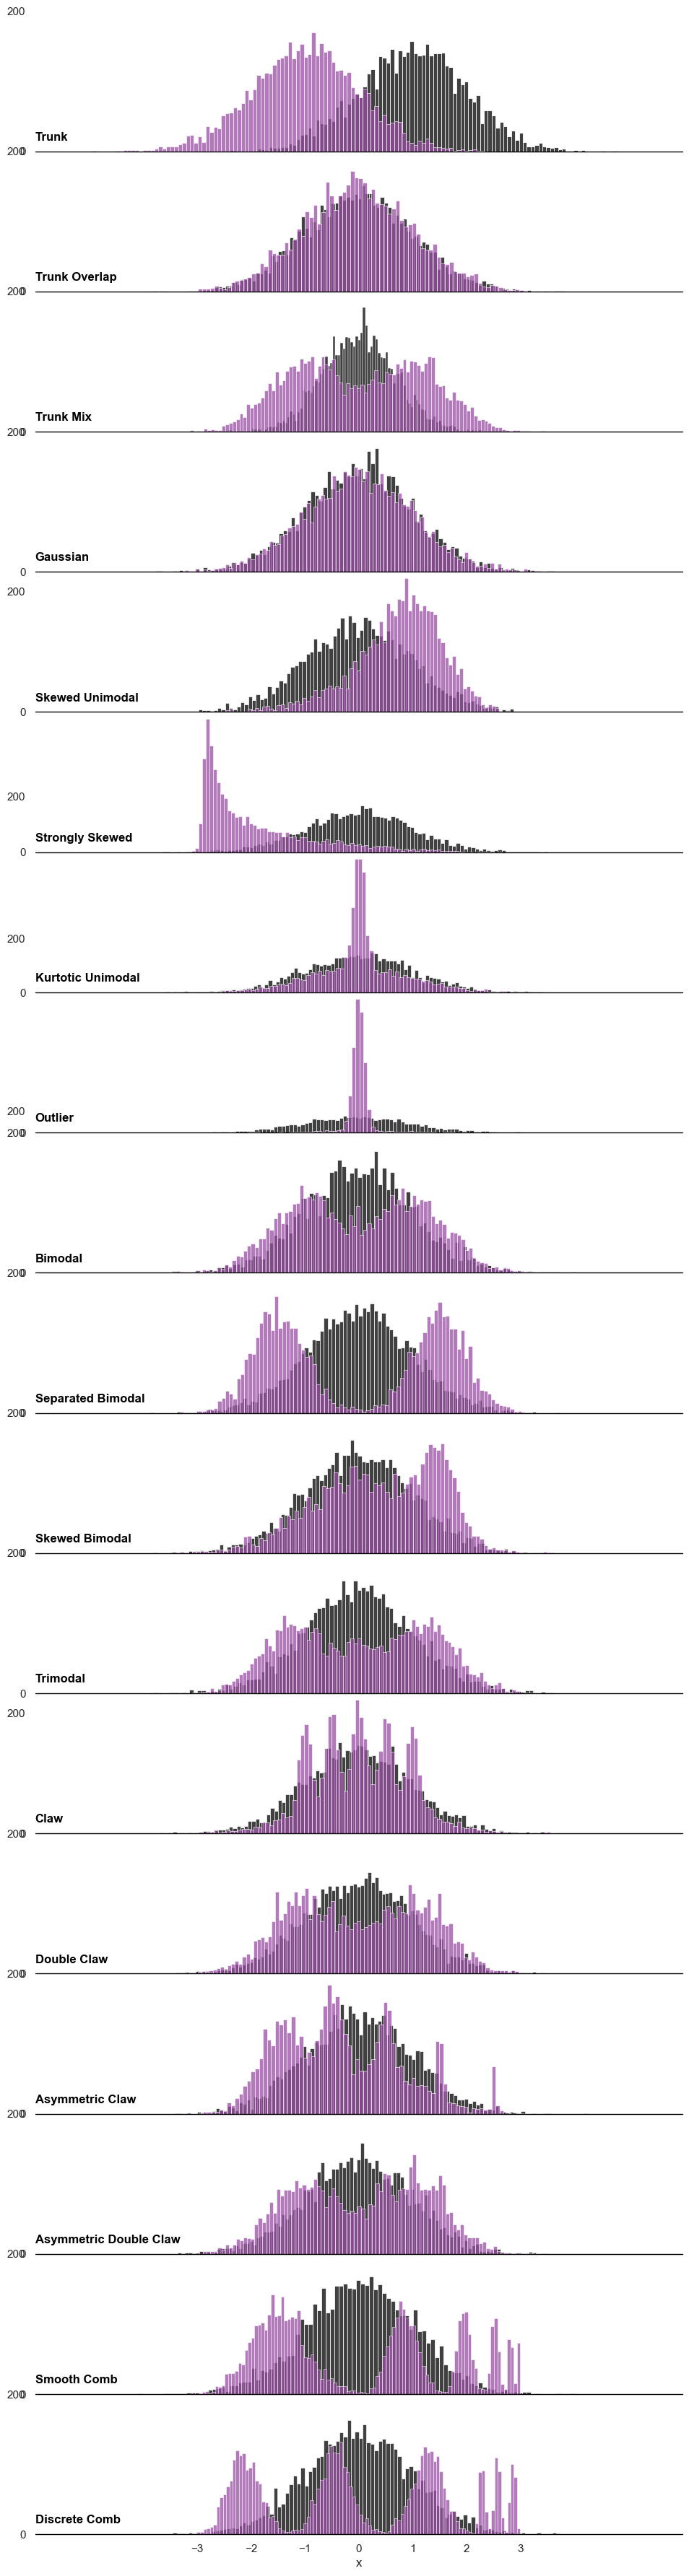

In [130]:
plot_sims_oned(n=10000)

In [131]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

SIMULATIONS = {
    "Trunk" : {"simulation" : "trunk"},
    "Trunk Overlap" : {"simulation" : "trunk_overlap"},
    "Trunk Mix" : {"simulation" : "trunk_mix"},
    "Gaussian" : {"simulation" : "gaussian"},
    "Skewed Unimodal" : {"simulation" : "skewed_unimodal"},
    "Strongly Skewed" : {"simulation" : "strongly_skewed"},
    "Kurtotic Unimodal" : {"simulation" : "kurtotic_unimodal"},
    "Outlier" : {"simulation" : "outlier"},
    "Bimodal" : {"simulation" : "bimodal"},
    "Separated Bimodal" : {"simulation" : "separated_bimodal"},
    "Skewed Bimodal" : {"simulation" : "skewed_bimodal"},
    "Trimodal" : {"simulation" : "trimodal"},
    "Claw" : {"simulation" : "claw"},
    "Double Claw" : {"simulation" : "double_claw"},
    "Asymmetric Claw" : {"simulation" : "asymmetric_claw"},
    "Asymmetric Double Claw" : {"simulation" : "asymmetric_double_claw"},
    "Smooth Comb" : {"simulation" : "smooth_comb"},
    "Discrete Comb" : {"simulation" : "discrete_comb"},
}

def plot_true_sims_dimensions(n, DIM=1):
    # Create the true pdf data
    xs = []
    ys = []
    spans = []
    g = np.concatenate([np.repeat(sim_title, n) for sim_title in SIMULATIONS.keys()])
    for sim, sim_kwargs in SIMULATIONS.items():
        span, pop1, pop2 = TrueSimulationDensities(n_samples=n, n_dim=DIM)(**sim_kwargs)
        xs.append(pop1[:])
        ys.append(pop2[:])
        spans.append(span)
    df = pd.DataFrame(dict(x=np.vstack(xs).ravel(), g=g, y=np.vstack(ys).ravel(), spans=np.vstack(spans).ravel()))
    # g = np.concatenate([np.repeat(2**i, n // 2) for i in range(1)])
    # x, y = make_trunk_classification(n_samples=n, n_dim=1, **SIMULATIONS[sim])
    # pop1 = np.hstack([x[:n // 2, i-1] for i in set(g)])
    # pop2 = np.hstack([x[n // 2:, i-1] for i in set(g)])
    # df = pd.DataFrame(dict(x=np.ravel(pop1.T), g=g, y=np.ravel(pop2.T)))

    # Initialize the FacetGrid object
    g = sns.FacetGrid(df, row="g", hue="g", aspect=5, height=2, palette=["#000000"], sharey=False)

    # # Draw the densities
    g.map(plt.plot, "spans", "x", color="#000000")
    g.map(plt.plot, "spans", "y", color="#984ea3")
    # g.map(sns.histplot, "x", bins=100, color="#000000") #, clip=(-3, 3), fill=False, alpha=0.5, linewidth=1.5, color="#000000")
    # g.map(sns.histplot, "y", bins=100, color="#984ea3") #, clip=(-3, 3), fill=False, alpha=0.5, linewidth=1.5, color="#000000")

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=1, linestyle="-", color=None, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, 0.1, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    
    g.map(label, "x")
    
    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=0)
    
    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(ylabel="", xlim=(-6, 6), xticks=[-3, -2, -1, 0, 1, 2, 3])
    g.despine(bottom=True, left=True)

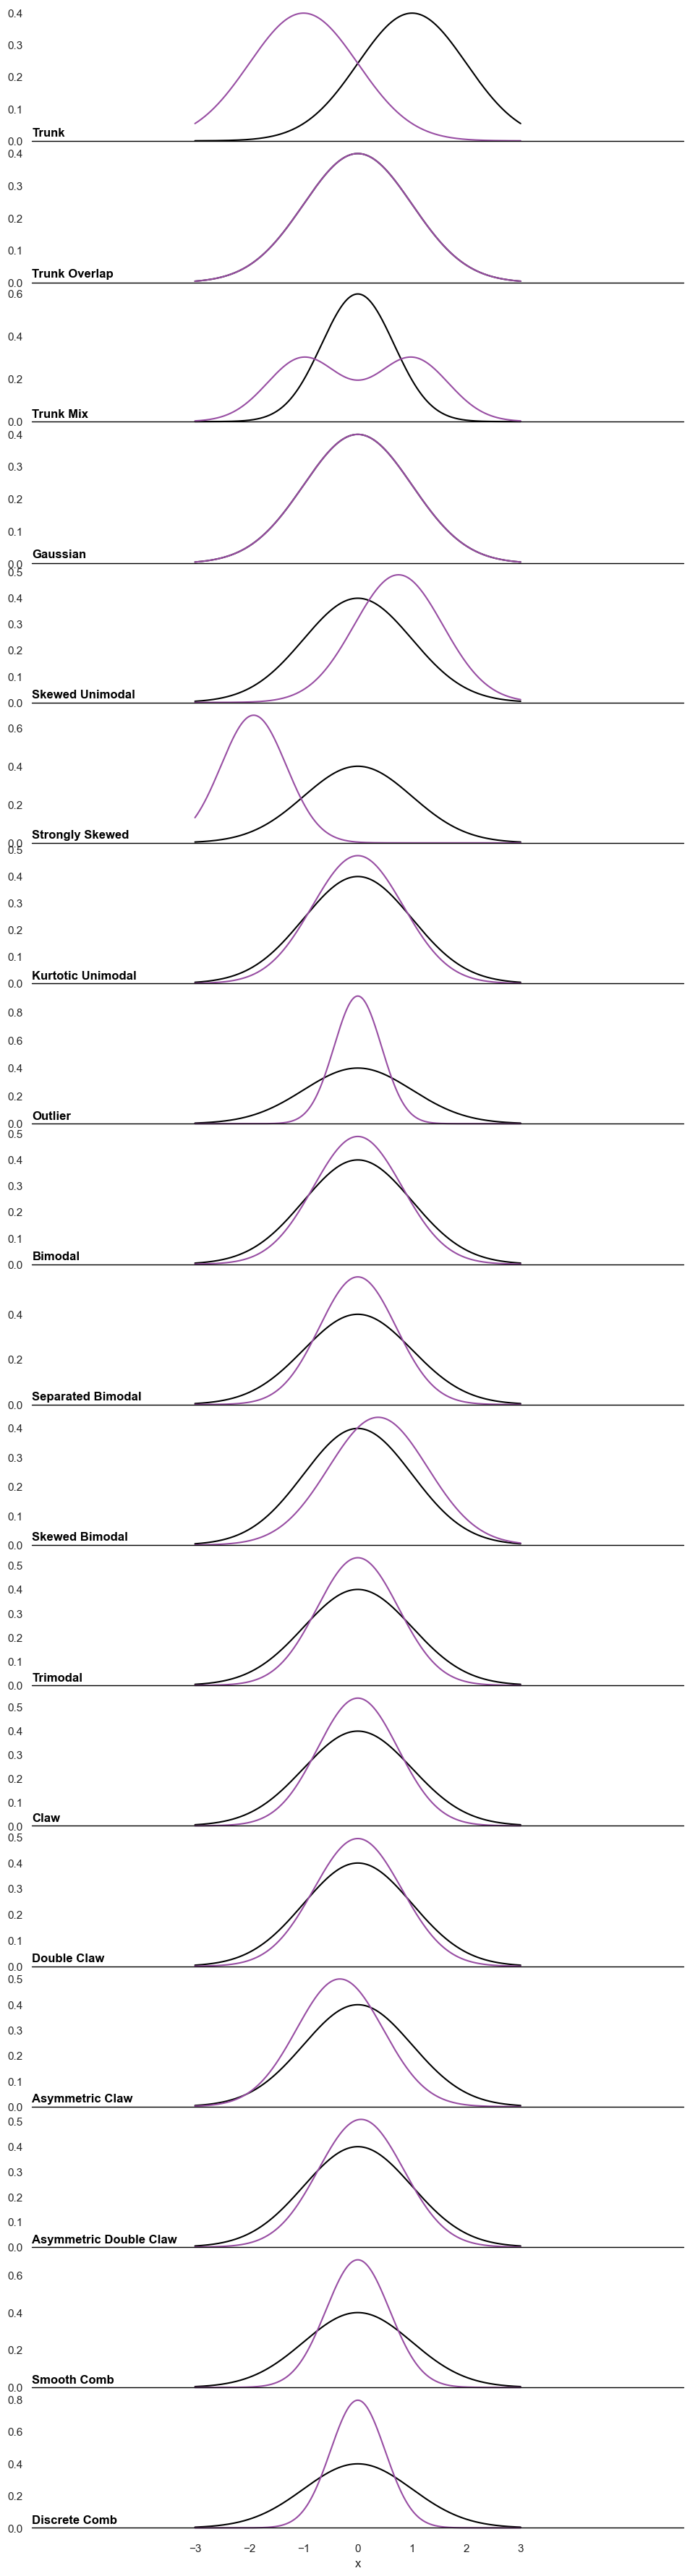

In [78]:
plot_true_sims_dimensions(n=1000, DIM=1)

In [132]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

SIMULATIONS = {
    "Trunk" : {"simulation" : "trunk"},
    "Trunk Overlap" : {"simulation" : "trunk_overlap"},
    "Trunk Mix" : {"simulation" : "trunk_mix"},
    "Gaussian" : {"simulation" : "gaussian"},
    "Skewed Unimodal" : {"simulation" : "skewed_unimodal"},
    "Strongly Skewed" : {"simulation" : "strongly_skewed"},
    "Kurtotic Unimodal" : {"simulation" : "kurtotic_unimodal"},
    "Outlier" : {"simulation" : "outlier"},
    "Bimodal" : {"simulation" : "bimodal"},
    "Separated Bimodal" : {"simulation" : "separated_bimodal"},
    "Skewed Bimodal" : {"simulation" : "skewed_bimodal"},
    "Trimodal" : {"simulation" : "trimodal"},
    "Claw" : {"simulation" : "claw"},
    "Double Claw" : {"simulation" : "double_claw"},
    "Asymmetric Claw" : {"simulation" : "asymmetric_claw"},
    "Asymmetric Double Claw" : {"simulation" : "asymmetric_double_claw"},
    "Smooth Comb" : {"simulation" : "smooth_comb"},
    "Discrete Comb" : {"simulation" : "discrete_comb"},
}

def plot_true_and_sim_1dim(n,DIM=128):
    # Create the data
    xs = []
    ys = []
    spans = []
    g = np.concatenate([np.repeat(sim_title, n) for sim_title in SIMULATIONS.keys()])
    for sim, sim_kwargs in SIMULATIONS.items():
        span, pop1, pop2 = TrueSimulationDensities(n_samples=n, n_dim=DIM)(**sim_kwargs)
        xs.append(pop1)
        ys.append(pop2)
        spans.append(span)
    df = pd.DataFrame(dict(x=np.vstack(xs).ravel(), g=g, y=np.vstack(ys).ravel(), spans=np.vstack(spans).ravel()))

    # Create the pdf
    xs = []
    ys = []
    g = np.concatenate([np.repeat(sim_title, n) for sim_title in SIMULATIONS.keys()])
    for sim, sim_kwargs in SIMULATIONS.items():
        x, _ = make_trunk_classification(n_samples=2*n, n_dim=DIM, **sim_kwargs)
        xs.append(x[:n, DIM-1])
        ys.append(x[n:, DIM-1])
    df_true = pd.DataFrame(dict(x_true=np.vstack(xs).ravel(), g_true=g, y_true=np.vstack(ys).ravel()))

    assert (len(df.g) == len(df_true.g_true))
    assert (len(df.y) == len(df_true.y_true))
    # concatenate the data
    df = pd.concat([df, df_true], axis=1)

    # Initialize the FacetGrid object
    g = sns.FacetGrid(df, row="g", hue="g", aspect=5, height=2, palette=["#000000"], sharey=False)

    # # # Draw the densities
    g.map(plt.plot, "spans", "x", color="#000000")
    g.map(plt.plot, "spans", "y", color="#984ea3")
    g.map(sns.histplot, "x_true", bins=100, stat="density", color="#000000", ) #, clip=(-3, 3), fill=False, alpha=0.5, linewidth=1.5, color="#000000")
    g.map(sns.histplot, "y_true", bins=100, stat="density", color="#984ea3") #, clip=(-3, 3), fill=False, alpha=0.5, linewidth=1.5, color="#000000")

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=1, linestyle="-", color=None, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, 0.1, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    
    g.map(label, "x")
    
    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=0)
    
    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(ylabel="", xlim=(-6, 6), xticks=[-3, -2, -1, 0, 1, 2, 3])
    g.despine(bottom=True, left=True)

/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

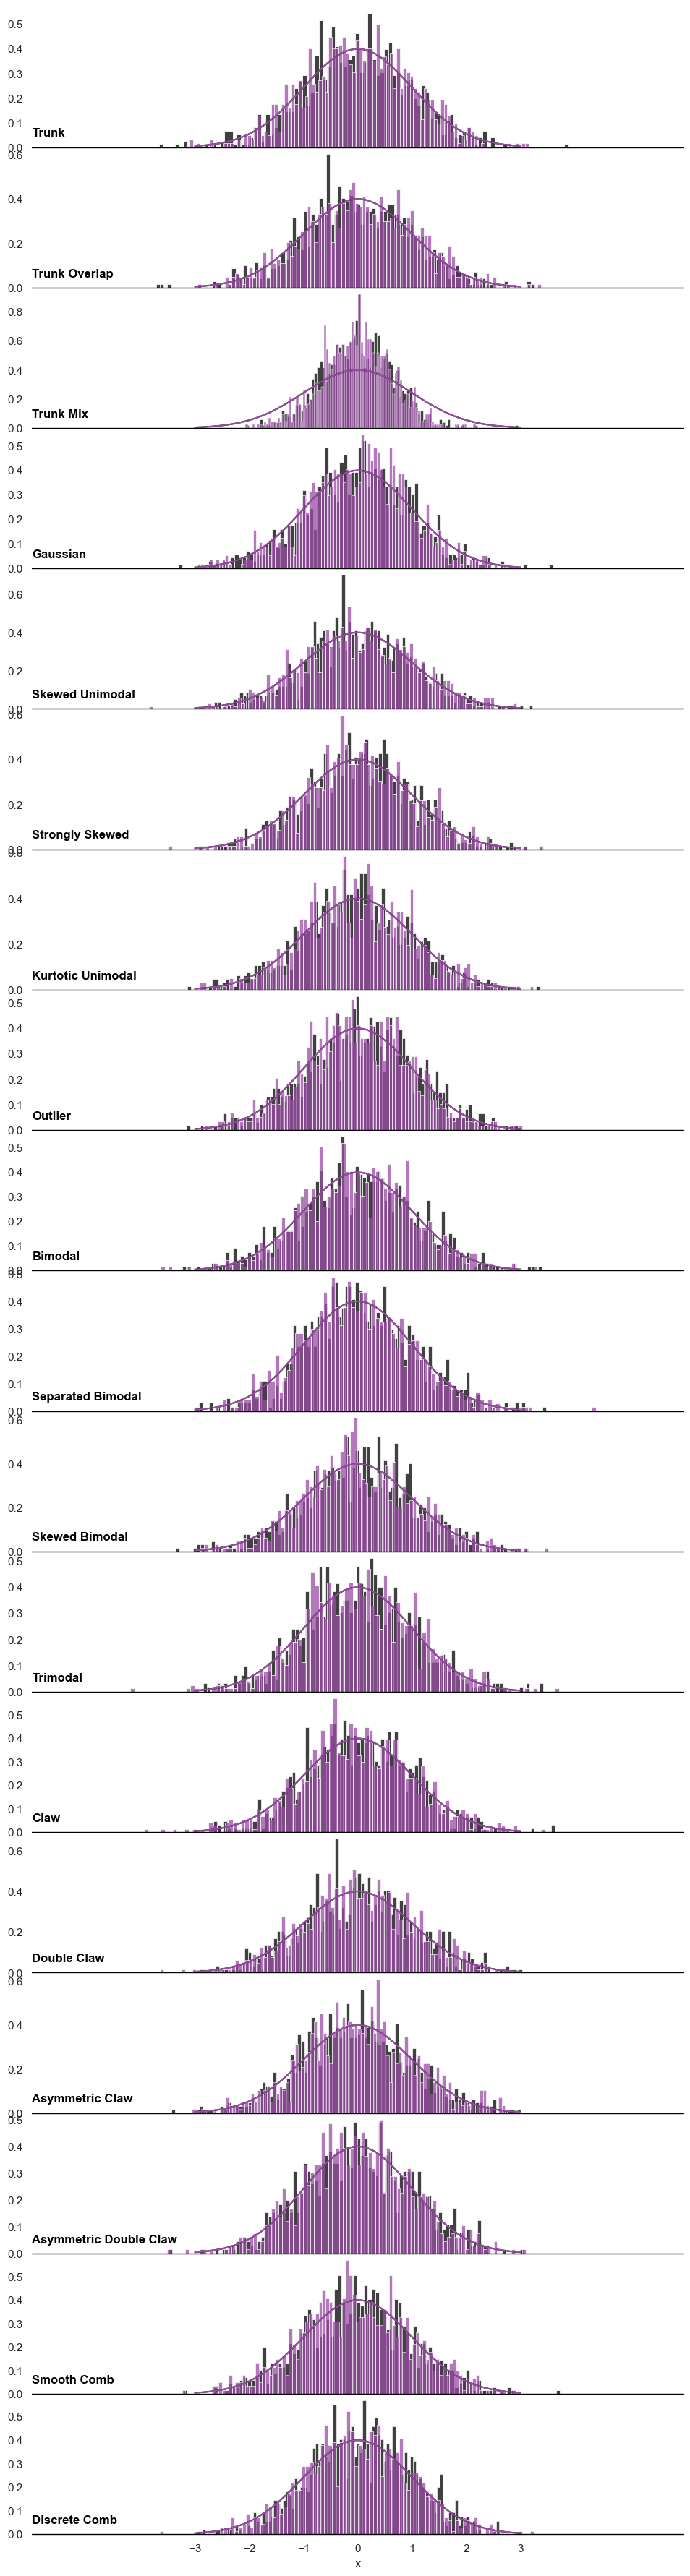

In [137]:
plot_true_and_sim_1dim(n=1000, DIM=257)